In [2]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import torchtext
from torchtext.legacy import data
import spacy
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pad_packed_sequence
from tqdm import tqdm
from torch.autograd import Variable
import pickle

In [3]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
spacy_en=spacy.load("en_core_web_sm",disable=['parser','tagger'])
def tokenizer(text):
    return [i.text for i in spacy_en.tokenizer(text) if not i.is_punct and not i.is_stop]
TEXT = data.Field(tokenize=tokenizer,batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True,use_vocab=False,preprocessing=data.Pipeline(lambda x: float(x)))

In [5]:
fields=[('review',TEXT),('sentiment',LABEL)]

In [6]:
path='D:/Projects/IMDb_Reviews.csv'
training_data=data.TabularDataset(path=path,format='csv',fields=fields,skip_header=True)
print(vars(training_data.examples[0]))

{'review': ['family', 'normally', 'watch', 'local', 'movies', 'simple', 'reason', 'poorly', 'lack', 'depth', 'worth', 'time.<br', '/><br', '/>The', 'trailer', 'Nasaan', 'ka', 'man', 'caught', 'attention', 'daughter', 'law', 'daughter', 'took', 'time', 'watch', 'afternoon', 'movie', 'exceeded', 'expectations', 'cinematography', 'good', 'story', 'beautiful', 'acting', 'awesome', 'Jericho', 'Rosales', 'good', 'Claudine', 'Barretto', 'fact', 'despised', 'Diether', 'Ocampo', 'proves', 'effective', 'role', 'touched', 'moved', 'affected', 'local', 'movie', 'Imagine', 'cynic', 'like', 'dabbing', 'eyes', 'end', 'movie', 'Congratulations', 'Star', 'Cinema', 'Way', 'Jericho', 'Claudine'], 'sentiment': 1.0}


In [7]:
TEXT.build_vocab(training_data,min_freq=4)
train_iter = data.Iterator(training_data, batch_size=64, sort_key=lambda x: len(x.review),
                           sort_within_batch=True, shuffle=True,device=device)

In [8]:
batch = next(iter(train_iter))
batch


[torchtext.legacy.data.batch.Batch of size 64]
	[.review]:('[torch.cuda.LongTensor of size 64x784 (GPU 0)]', '[torch.cuda.LongTensor of size 64 (GPU 0)]')
	[.sentiment]:[torch.cuda.FloatTensor of size 64 (GPU 0)]

In [28]:
class RNN(nn.Module):
    def __init__(self,vocab_size,batch_size,emd_dim,hidden_dim,out_dim,n_layers):
        super(RNN,self).__init__()
        self.n_layers=n_layers
        self.batch_size=batch_size
        self.hidden_dim=hidden_dim
        self.embedding=nn.Embedding(vocab_size,emd_dim)
        self.gru=nn.GRU(emd_dim,hidden_dim,num_layers=n_layers,batch_first=True)
        self.fc=nn.Linear(hidden_dim,out_dim)
        self.sigmoid=nn.Sigmoid()
    def _init_hidden(self,bs):
        return torch.zeros(self.n_layers,bs,self.hidden_dim,device=device)
    def forward(self,txt,txt_lengths):
        embs=self.embedding(txt)
        packed_embs = nn.utils.rnn.pack_padded_sequence(embs, txt_lengths,batch_first=True)
        hidden=self._init_hidden(txt.size(0))
        packed_output,hidden=self.gru(packed_embs,hidden)
        outputs=self.sigmoid(self.fc(hidden))
        return outputs.squeeze()

In [29]:
vocab_size=len(TEXT.vocab)
emd_dim=100
batch_size=64
hidden_dim=32
out_dim=1
n_layers=1
model=RNN(vocab_size,batch_size,emd_dim,hidden_dim,out_dim,n_layers).to(device)

In [30]:
model(batch.review[0],batch.review[1].cpu().numpy()).shape

torch.Size([64])

In [31]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

In [32]:
def accuracy(preds,targets):
    preds=torch.round(preds)
    return (preds==targets).cpu().sum().float()/preds.size(0)

In [33]:
train_loss_epoch=[]
acc_epoch=[]
model.train()
for epoch in tqdm(range(30)):
    losses=0.0
    accs=0.0
    for batch in train_iter:
        optimizer.zero_grad()
        texts,text_lengths=batch.review
        texts=Variable(texts)
        labels=Variable(batch.sentiment)
        model._init_hidden(texts.size(0))
        predictions=model(texts,text_lengths.cpu().numpy())
        loss=criterion(predictions,labels)
        acc=accuracy(predictions,labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
        losses+=loss.item()
        accs+=acc.item()
    train_loss_epoch.append(losses/len(train_iter))
    acc_epoch.append(accs/len(train_iter))

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [13:05<00:00, 26.17s/it]


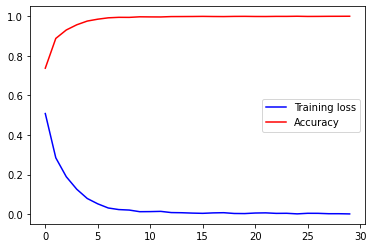

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(30),train_loss_epoch,color='b')
plt.plot(range(30),acc_epoch,color='r')
plt.legend(['Training loss','Accuracy'])
plt.show()

In [35]:
torch.save(model.state_dict(), 'D:/Projects/model_weights.pt')

In [36]:
with open('D:/Projects/tokenizer.pickle','wb') as f:
    pickle.dump(TEXT.vocab.stoi,f)

In [37]:
with open('D:/Projects/vocabs.pickle','wb') as f:
    pickle.dump(TEXT.vocab,f)